# Timing Data

In [1]:
import sys
import statistics
import numpy
from itertools import product
from timeit import default_timer as timer
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
print(sys.path)
from tqdm import tqdm
import gillespy2
from scipy import stats

['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/dalton/.local/lib/python3.6/site-packages', '/usr/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/dalton/.ipython', '/home/dalton/environments/GillesPy2']


In [2]:
from gillespy2.basic_ssa_solver import BasicSSASolver
from gillespy2.ssa_c_solver import SSACSolver
from gillespy2.basic_root_solver import BasicRootSolver
from gillespy2.optimized_ssa_solver import OptimizedSSASolver
from gillespy2 import StochKitSolver
from gillespy2.example_models import *
import pickle
StochKitSolver.name = 'StochKitSolver'
SSASolver = OptimizedSSASolver(use_cython = False)
CythonSSASolver = OptimizedSSASolver(use_cython=True)
assert CythonSSASolver.name == 'CythonSSASolver'
modelList = [Example(), Trichloroethylene(), MichaelisMenten(), Schlogl()]
solverList = [SSASolver, CythonSSASolver, StochKitSolver, SSACSolver]

In [12]:
MAX_TRAJS = 10 #2**MAX_TRAJS
timing_data = {}


#For some of the slower solvers, we are not worried about some of
#the minor fluctuations in runtime compared to the StochKit and C based solvers.
def number_trials(solver_name, trajectories):
    if solver_name in ['CythonSSASolver','StochKitSolver','SSACSolver'] or trajectories <= 256:
        return 30
    return 3 #For the slower solvers, run less at larger problem sizes


for model in modelList:
    timing_data[model.name] = {}
    
for model, solver in product(modelList, solverList):
    #The SSACSolver can be precompiled for the same model
    #with different numbers of trajectories, timesteps, etc
    if solver == SSACSolver:
        solver = SSACSolver(model)
    timing_data[model.name][solver.name] = []
    for traj in range(MAX_TRAJS):
        medianList = []
        exterior_stats = []
        trials = number_trials(solver.name, 2 ** traj)
        for i in tqdm(range(trials), desc = f'Model: {model.name}, Solver: {solver.name}, Trajectories: {2**traj}'):
            start = timer()
            test_results = model.run(solver=solver, number_of_trajectories=2**traj)
            stop = timer()
            medianList.append(stop-start)
        median = statistics.median(medianList)
        mean = statistics.mean(medianList)
        timing_data[model.name][solver.name].append((median, mean, trials))
        with open('timing_data.pkl', 'wb') as f:
            pickle.dump(timing_data, f)

Model: Example, Solver: OptimizedSSASolver, Trajectories: 1: 100%|██████████| 30/30 [00:00<00:00, 365.80it/s]
Model: Example, Solver: OptimizedSSASolver, Trajectories: 2: 100%|██████████| 30/30 [00:00<00:00, 183.36it/s]
Model: Example, Solver: OptimizedSSASolver, Trajectories: 4: 100%|██████████| 30/30 [00:00<00:00, 99.59it/s] 
Model: Example, Solver: OptimizedSSASolver, Trajectories: 8: 100%|██████████| 30/30 [00:00<00:00, 48.40it/s]
Model: Example, Solver: OptimizedSSASolver, Trajectories: 16: 100%|██████████| 30/30 [00:01<00:00, 24.65it/s]
Model: Example, Solver: CythonSSASolver, Trajectories: 1: 100%|██████████| 30/30 [00:00<00:00, 1236.98it/s]
Model: Example, Solver: CythonSSASolver, Trajectories: 2: 100%|██████████| 30/30 [00:00<00:00, 499.22it/s]
Model: Example, Solver: CythonSSASolver, Trajectories: 4: 100%|██████████| 30/30 [00:00<00:00, 353.37it/s]
Model: Example, Solver: CythonSSASolver, Trajectories: 8: 100%|██████████| 30/30 [00:00<00:00, 187.62it/s]
Model: Example, Solver

KeyboardInterrupt: 

In [5]:
print(timing_data)

{'Example': {'OptimizedSSASolver': [(0.002995346999796311, 0.0035967430665853803, 30), (0.005037047500081826, 0.005430789733448667, 30), (0.009569482000188145, 0.010318860266609893, 30), (0.018714922999606642, 0.02011900139999246, 30), (0.039608139500614925, 0.04026551450009113, 30), (0.07679416349992607, 0.07649427116669662, 30), (0.15664365599968733, 0.15705399220005348, 30), (0.28899644600051033, 0.2923366526331847, 30), (0.5907007840000915, 0.5957434564999857, 30), (1.1950841879997824, 1.1915630573330418, 3)], 'CythonSSASolver': [(0.0007359384999290342, 0.0009029310667453198, 30), (0.0012881049997304217, 0.001670415933131153, 30), (0.0021538869996220456, 0.0027159843999470467, 30), (0.004171743999449973, 0.005004085533316053, 30), (0.008282572999632976, 0.008889204466716668, 30), (0.016234581999924558, 0.01783303513335947, 30), (0.03460374550013512, 0.03536506273333847, 30), (0.06745105999971202, 0.06872403556665935, 30), (0.1399842720002198, 0.1377588259000125, 30), (0.26302909349

In [6]:
#Ideally, we can run the timed tests once and save the results for later in a .pkl file
import pickle
timing_data = None
with open('timing_data.pkl', 'rb') as f:
    timing_data = pickle.load(f)

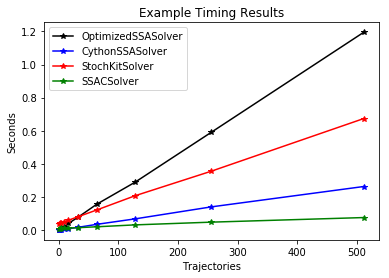

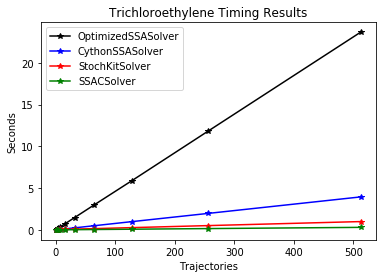

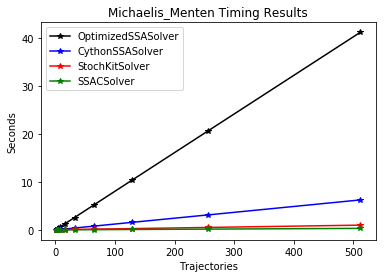

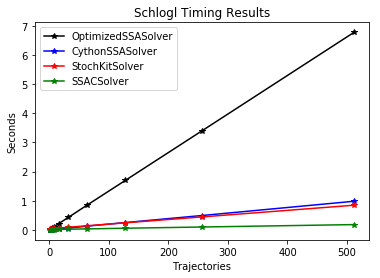

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
trajs = [2 ** i for i in range(MAX_TRAJS)]
line_style = {
    'StochKitSolver' : 'r*-',
    'SSACSolver' : 'g*-',
    'CythonSSASolver' : 'b*-',
    'OptimizedSSASolver' : 'k*-'    
}


for model in modelList:
    plt.figure()
    plt.title('{} Timing Results'.format(model.name))
    plt.xlabel('Trajectories')
    plt.ylabel('Seconds')
    for solver in solverList:
        if False and solver.name == 'OptimizedSSASolver':
            continue
        times = [timing_data[model.name][solver.name][i][0] for i in range(len(timing_data[model.name][solver.name]))]
        plt.plot(trajs, times, line_style[solver.name], label='{}'.format(solver.name))
    plt.legend(loc='best')
    plt.savefig('{}TimingResults.png'.format(model.name))

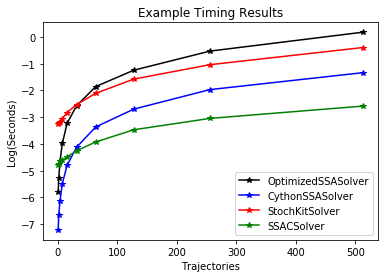

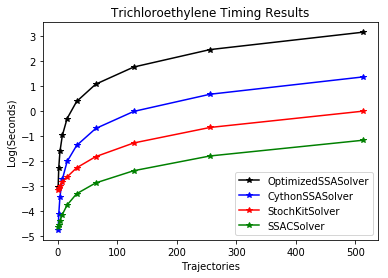

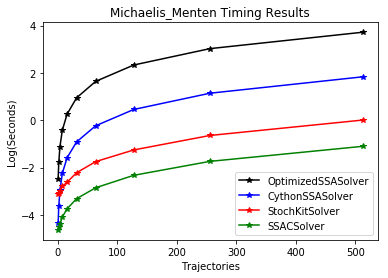

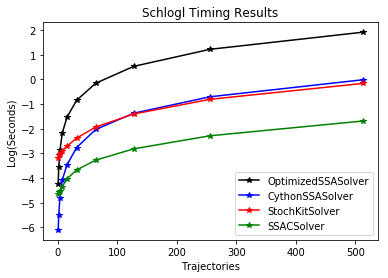

In [8]:
import matplotlib.pyplot as plt
import math
%matplotlib inline
trajs = [2 ** i for i in range(MAX_TRAJS)]
for model in modelList:
    plt.figure()
    plt.title('{} Timing Results'.format(model.name))
    plt.xlabel('Trajectories')
    plt.ylabel('Log(Seconds)')
    for solver in solverList:
        times = [math.log(timing_data[model.name][solver.name][i][0]) for i in range(len(timing_data[model.name][solver.name]))]
        plt.plot(trajs, times, line_style[solver.name], label='{}'.format(solver.name))
    plt.legend(loc='best')
    plt.savefig('{}LogTimingResults.png'.format(model.name))

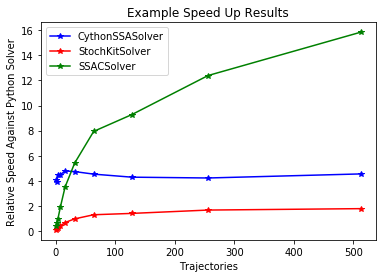

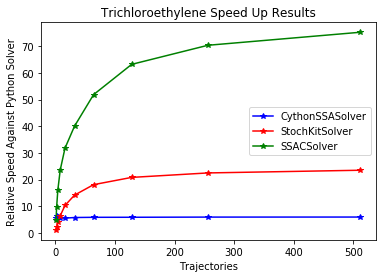

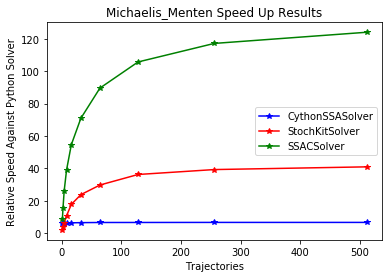

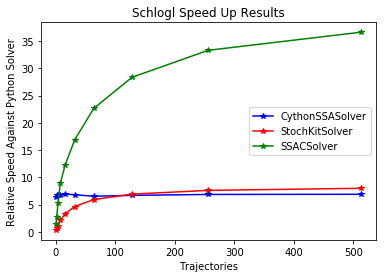

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
trajs = [2 ** i for i in range(MAX_TRAJS)]
line_style = {
    'StochKitSolver' : 'r*-',
    'SSACSolver' : 'g*-',
    'CythonSSASolver' : 'b*-',
    'OptimizedSSASolver' : 'k*-'    
}


for model in modelList:
    plt.figure()
    plt.title('{} Speed Up Results'.format(model.name))
    plt.xlabel('Trajectories')
    plt.ylabel('Relative Speed Against Python Solver')
    for solver in solverList:
        if solver.name == 'OptimizedSSASolver':
            continue
        times = [timing_data[model.name]['OptimizedSSASolver'][i][0]/timing_data[model.name][solver.name][i][0] for i in range(len(timing_data[model.name][solver.name]))]
        plt.plot(trajs, times, line_style[solver.name], label='{}'.format(solver.name))
    plt.legend(loc='best')
    plt.savefig('{}SpeedupResults.png'.format(model.name))

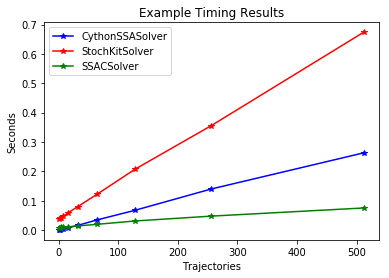

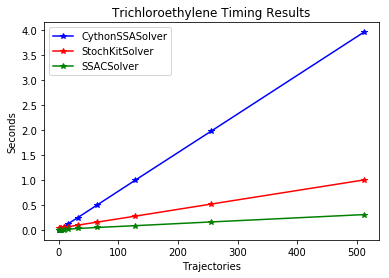

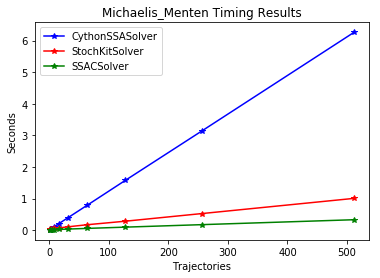

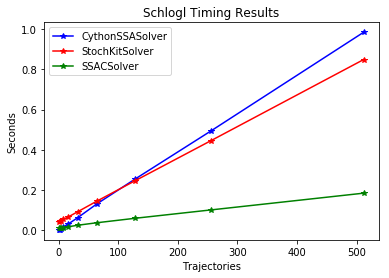

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
trajs = [2 ** i for i in range(MAX_TRAJS)]
line_style = {
    'StochKitSolver' : 'r*-',
    'SSACSolver' : 'g*-',
    'CythonSSASolver' : 'b*-',
    'OptimizedSSASolver' : 'k*-'    
}


for model in modelList:
    plt.figure()
    plt.title('{} Timing Results'.format(model.name))
    plt.xlabel('Trajectories')
    plt.ylabel('Seconds')
    for solver in solverList:
        if solver.name == 'OptimizedSSASolver':
            continue
        times = [timing_data[model.name][solver.name][i][0] for i in range(len(timing_data[model.name][solver.name]))]
        plt.plot(trajs, times, line_style[solver.name], label='{}'.format(solver.name))
    plt.legend(loc='best')
    plt.savefig('{}TimingResults.png'.format(model.name))